<a href="https://colab.research.google.com/github/lnpanh/CSC14116/blob/lnpanh/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINAL REPORT

Course: Applied Parallel Programming

18127039 -  Lâm Ngọc Phương Anh

18127046 - Lư Ngọc Liên 

1653098 - Võ Minh Tú


# Enhancing Document Image


## Problem Statement

### Overview
Enhancing document image is a fundamental stage in image processing which support scan images, convert images to text, and re-align shooting angles,...

The problem is divided into two main steps:
- Step 1: Align the photo, remove the excess background around
- Step 2: Adjust the brightness and contrast of the photo

Common applications where this problem applies are:
- Scanning function of iPhone Notes 
- CamScanner app



 
### Input and Output Data description
* Input: a document image is not facing toward the screen.
* Output: the document image (cut the background) faces toward the screen.
* Example of input and output:

![](https://i.imgur.com/8cfHARR.png)

*cre*: [dropbox.Tech, Jongmin Baek, Aug 16, 2016, Fast document rectification and enhancement](https://dropbox.tech/machine-learning/fast-document-rectification-and-enhancement)

* **Steps of processing the image from Input to Output**
    * Detect edges
    * Get the document's contour based on the detected edges above.
    * Apply transform to get the top-down view of the image.
    * Adjust the contrast and light to make the document easier to read.



#### Bước 3: Đưa ảnh tài liệu về đối diện màn hình
* Lúc này, ta sẽ lấy các pixel nằm bên trong viền đã được nhận diện ở bước trước đó, thực hiện việc map các điểm ảnh này sang một không gian tọa độ mới (đối diện màn hình).

* Các hướng tiếp cận cho bước có điểm chung là đều được thực hiện bằng cách nhân ma trận trên một hệ tọa độ đồng nhất ([Homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates)):

    * Sử dụng các **phép xoay ảnh**: Xoay bức ảnh quanh một điểm theo một góc xác định nào đó, vẫn giữ nguyên các tính chất của ảnh (các góc của ảnh vẫn giữ nguyên).
    * Sử dụng phép biến đổi affine: Cần xác định ba điểm trên ảnh gốc và vị trí của chúng trên ảnh kết quả. Biến đổi affine giúp tạo ra nhiều tư thế, biến thể khác nhau của vật thể. Các biến thể này sẽ được bảo toàn tính song song, tỉ lệ khoảng cách của vật thể và các đường thẳng trong ảnh.
    * Sử dụng biến đổi phối cảnh (Perspective transform hoặc Homography transform): Đây là một phép biến đổi đặc biệt khi mà ảnh kết quả không được đảm bảo về góc, độ dài, tính song song so với ảnh gốc ngoại trừ bảo toàn đường thẳng.


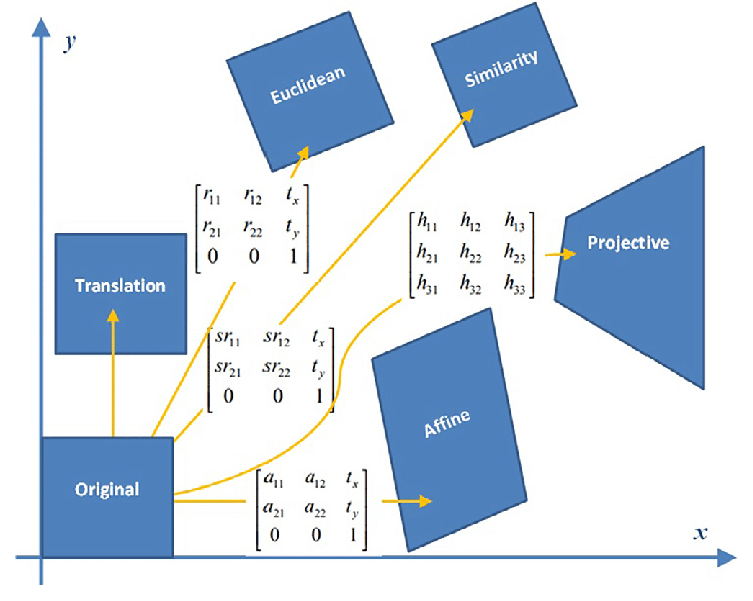

cre: A. Soycan - Metin Soycan (2018), Perspective correction of building facade images for architectural applications. Engineering Science and Technology an International Journal 22(3).

##### **Phép biến đổi Homography**

* Đối với bài toán này, hình dạng của văn bản trong ảnh đầu vào đa dạng và không phải luôn là chữ nhật $→$ **biến đổi phối cảnh** sẽ là giải pháp tốt nhất để có thể đưa văn bản về đối diện màn hình.

* Các bước thực hiện phép biến đổi Homography:
    1. Xác định 4 điểm góc của văn bản trong ảnh đầu vào (source points) và xem nó là 4 đỉnh của ảnh đầu ra (target points).
    2. Dựa trên 4 điểm đã chọn, tính chiều dài và rộng cho ảnh đầu ra $→$ xác định được tọa độ 4 đỉnh trong không gian mới và kích thước của ảnh output.
    3. Khi đã có được source và target points thì ta có thể dễ dàng tính được ma trận biến đổi **H** (3x3).
    4. Thực hiện việc chuyển đổi tọa độ cho từng điểm ảnh bằng công thức sau:
    $$dst(x,y) = src(\frac{H_{0,0}x + H_{0,1}y + H_{0,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}},\frac{H_{1,0}x + H_{1,1}y + H_{1,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}})$$ 


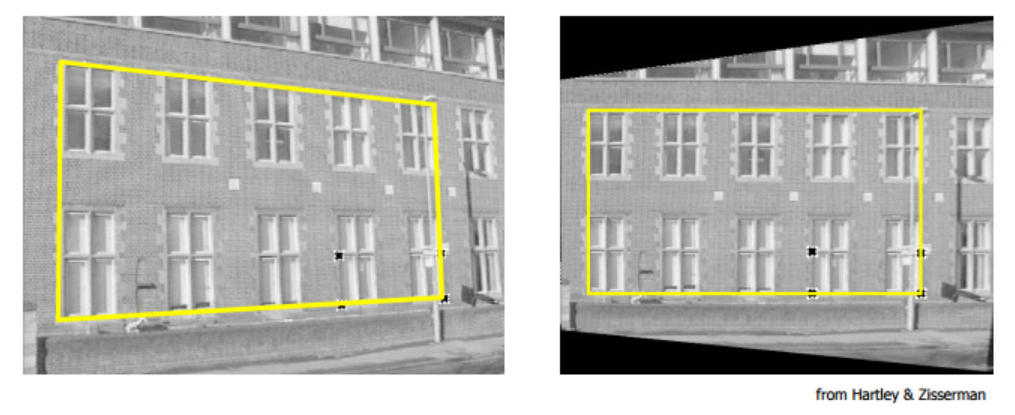

cre: [OpenCV, Basic concepts of the homography explained with code.](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html)

* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** vì có thể thấy tại bước 4 của quá trình này là việc xác định tọa độ mới của từng pixel, điều này có thể sẽ tốn nhiều thời gian khi kích thước bức ảnh lớn.
    * Có thể áp dụng lập trình song song vào **bước 4** vì các pixel sẽ được tính toán một cách độc lập.

## Code

In [1]:
import numpy as np
from numba import *
from PIL import *
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import math

from google.colab.patches import cv2_imshow
import imutils

import warnings
warnings.filterwarnings('ignore')

In [2]:
img_path = '/content/poster.png'
img = np.asarray(Image.open(img_path))

### Làm xám ảnh

* Dùng hàm của openCV

CPU times: user 2.72 ms, sys: 304 µs, total: 3.02 ms
Wall time: 19.1 ms


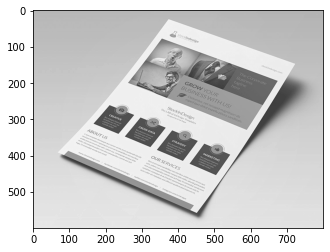

In [3]:
%time gray_cv = cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
plt.imshow(gray_cv, cmap='gray')
plt.show()

* Dùng hàm của numpy

In [4]:
def convert_RGB_Gray_np(img):
    return np.dot(img[...,:3],[0.2989, 0.5870, 0.1140])

CPU times: user 21 ms, sys: 3.84 ms, total: 24.8 ms
Wall time: 27.9 ms


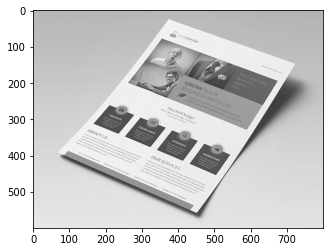

In [5]:
%time gray_np = convert_RGB_Gray_np(img)
plt.imshow(gray_np, cmap='gray')
plt.show()

* Sử dụng @jit cho python thuần

In [6]:
@jit(cache=True)
def convert_RGB_Gray_py(img):
    gray = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            gray[i,j] = img[i,j,0] * 0.2989  + img[i,j,1] * 0.5870 + img[i,j,2] * 0.1140
    return gray

In [7]:
%time gray_py = convert_RGB_Gray_py(img)

CPU times: user 437 ms, sys: 106 ms, total: 543 ms
Wall time: 489 ms


CPU times: user 1.93 ms, sys: 0 ns, total: 1.93 ms
Wall time: 2.2 ms


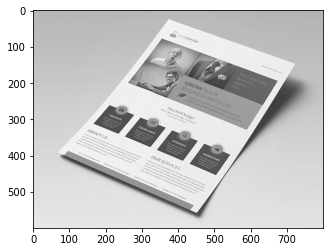

In [8]:
%time gray_py = convert_RGB_Gray_py(img)
plt.imshow(gray_py, cmap='gray')
plt.show()

* So sánh kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [9]:
print("openCV vs Numpy: ", np.abs(gray_cv - gray_np).mean())
print("openCV vs Python (@jit): ", np.abs(gray_cv - gray_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(gray_py - gray_np).mean())

openCV vs Numpy:  0.06334380208333712
openCV vs Python (@jit):  0.06334380208333712
Python (@jit) vs Numpy:  0.0


### Xác định biên cạnh bằng canny

* Thuật toán canny bao gồm 4 bước:
    * Giảm nhiễu: bước này sẽ sử dụng Gaussian kernel để làm mờ bức ảnh, bức ảnh càng mờ thì số lượng cạnh được phát hiện sẽ càng giảm -> chỉ những cạnh rõ nét được phát hiện -> tăng độ chính xác khi phát hiện cạnh của đối tượng.
    * Tính Gradient và hướng Graient: 
    * Non-maximum Suppression (NMS): 
    * Lọc ngưỡng: Bước nayf sẽ sử dụng hai ngưỡng threshold để lọc ra 3 loại pixel: trên ngưỡng max là cạnh, dưới ngưỡng min sẽ bị loại bỏ và những pixel nằm giữa hai ngưỡng sẽ xét có cận với các pixel chắc chắn là cạnh không.

CPU times: user 5.35 ms, sys: 1.77 ms, total: 7.12 ms
Wall time: 26.7 ms


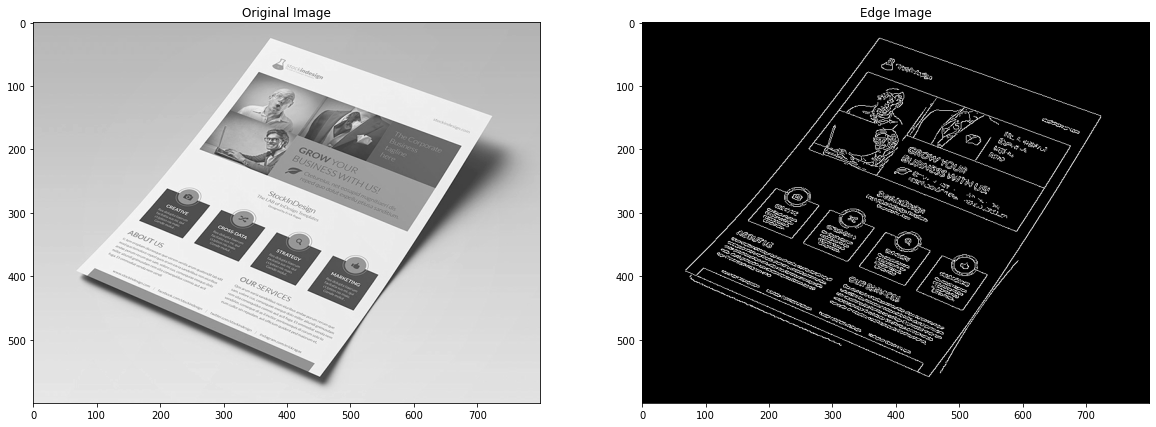

In [10]:
%time canny_edge_cv = cv2.Canny(gray_cv,100,200)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(gray_cv,cmap = 'gray');
axis[0].set_title('Original Image');
axis[1].imshow(canny_edge_cv,cmap = 'gray');
axis[1].set_title('Edge Image');

#### **Giảm nhiễu**

##### Một số hàm khởi tạo

In [11]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [12]:
gau_kernel_size = 5
gau_kernel = gaussian_kernel(gau_kernel_size)

* Dùng hàm của openCV

CPU times: user 2.41 ms, sys: 930 µs, total: 3.34 ms
Wall time: 5.02 ms


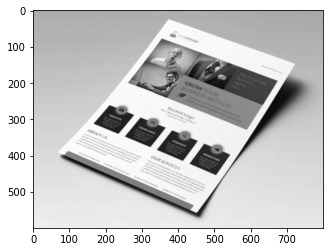

In [13]:
%time gaussianBlur_cv = cv2.GaussianBlur(gray_cv, (gau_kernel_size, gau_kernel_size), 1, 1, cv2.BORDER_REPLICATE)
plt.imshow(gaussianBlur_cv, cmap='gray')
plt.show()

* Dùng hàm của numpy

In [14]:
def convolutionLayer_np(img, kernel):
    rows_k, cols_k = kernel.shape
    rows, cols = img.shape
    
    return ndimage.filters.convolve(img, kernel, mode='reflect')

CPU times: user 23.2 ms, sys: 0 ns, total: 23.2 ms
Wall time: 30.2 ms


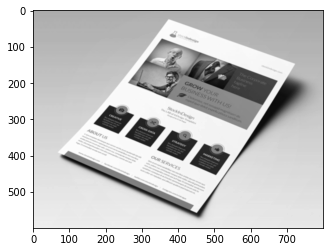

In [15]:
%time gaussianBlur_np = convolutionLayer_np(gray_np, gau_kernel)
plt.imshow(gaussianBlur_np, cmap='gray')
plt.show()

* Sử dụng @jit cho python thuần

In [16]:
@jit(cache=True)
def convolutionLayer_py(img, kernel):
    img_out = np.zeros(img.shape)
    rows, cols = img.shape
    rows_k, cols_k = kernel.shape
    for r in range(rows):
        for c in range(cols):
            out = 0
            for r_k in range(rows_k):
                for c_k in range(cols_k):
                    in_r = r - rows_k//2 + r_k;
                    in_c = c - cols_k//2 + c_k;
                    in_r = min(max(0, in_r), rows - 1);
                    in_c = min(max(0, in_c), cols - 1);
                    out += kernel[r_k,c_k] * img[in_r,in_c];
            img_out[r,c] = out
    return img_out

In [17]:
%time gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)

CPU times: user 319 ms, sys: 5.56 ms, total: 324 ms
Wall time: 329 ms


CPU times: user 31.7 ms, sys: 1.97 ms, total: 33.6 ms
Wall time: 34 ms


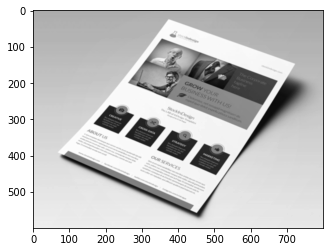

In [18]:
%time gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)
plt.imshow(gaussianBlur_py, cmap='gray')
plt.show()

* So sánh kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [19]:
print("openCV vs Numpy: ", np.abs(gaussianBlur_cv - gaussianBlur_np).mean())
print("openCV vs Python (@jit): ", np.abs(gaussianBlur_cv - gaussianBlur_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(gaussianBlur_py - gaussianBlur_np).mean())

openCV vs Numpy:  5.134454618369533
openCV vs Python (@jit):  5.133840892523962
Python (@jit) vs Numpy:  0.0006152727721604918


#### **Tính Gradient và hướng Gradient**

In [20]:
sobel_x_kernel, sobel_y_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32), np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)

* Sử dụng hàm của openCV

In [21]:
def edgeGradient_cv(img, is_L2_grad = True):
    sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize = 3)
    sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize = 3)
    edge_sobel = np.hypot(sobel_x, sobel_y) if is_L2_grad else np.abs(sobel_x) + np.abs(sobel_y)
    
    #convert radian value to degree
    angle = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    angle[angle<0] += 180
        
    return edge_sobel, angle

CPU times: user 28.1 ms, sys: 5.92 ms, total: 34 ms
Wall time: 36 ms


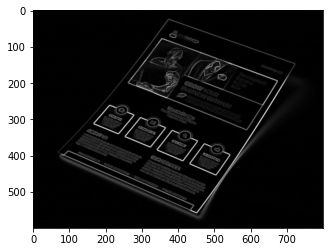

In [22]:
%time edge_sobel_cv, angle_cv = edgeGradient_cv(gaussianBlur_cv)
plt.imshow(edge_sobel_cv, cmap='gray')
plt.show()

* Sử dụng hàm của numpy

In [23]:
def edgeGradient_np(img, is_L2_grad = True):
    sobel_x = convolutionLayer_np(img,sobel_x_kernel)
    sobel_y = convolutionLayer_np(img,sobel_y_kernel)
    edge_sobel = np.hypot(sobel_x, sobel_y) if is_L2_grad else np.abs(sobel_x) + np.abs(sobel_y)
    
    #convert radian value to degree
    angle = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    angle[angle<0] += 180
        
    return edge_sobel, angle

CPU times: user 45.7 ms, sys: 10 ms, total: 55.7 ms
Wall time: 61 ms


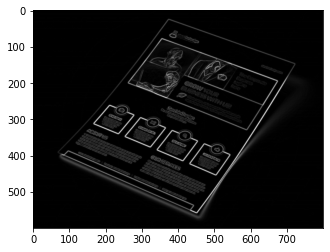

In [24]:
%time edge_sobel_np, angle_np = edgeGradient_np(gaussianBlur_np)
plt.imshow(edge_sobel_np, cmap='gray')
plt.show()

* Sử dụng @jit cho python thuần

In [25]:
@jit(cache=True)
def matrixElementWise(mat1, mat2 = None, op='*', is_scalar = False):
    out_mat = np.zeros(mat1.shape)
    if is_scalar:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2        
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2
    else:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2[i,j]
        elif op == 'sqrt':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] ** 0.5
        elif op == 'abs':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = abs(mat1[i,j])
        elif op == 'arctan2':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = math.atan2(mat1[i,j], mat2[i,j])
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2[i,j]
    
    return out_mat

In [26]:
@jit(cache=True)
def edgeGradient_py(img, is_L2_grad = True):
    sobel_x = convolutionLayer_py(img,sobel_x_kernel)
    sobel_y = convolutionLayer_py(img,sobel_y_kernel)
    
    edge_sobel = matrixElementWise(
        matrixElementWise(
            matrixElementWise(sobel_x,sobel_x), 
            matrixElementWise(sobel_y,sobel_y), 
            op='+'),
        op='sqrt') if is_L2_grad else matrixElementWise(
        matrixElementWise(
            sobel_x, op='abs'
        ), matrixElementWise(
            sobel_y, op='abs'), 
        op='+')
    
    #convert radian value to degree
    angle = matrixElementWise(
        matrixElementWise(
            sobel_y, 
            sobel_x, 
            op='arctan2'),
        (180 / np.pi),
        is_scalar=True)
    
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if angle[r,c] < 0:
                angle[r,c] += 180
                    
    return edge_sobel, angle

In [27]:
%time edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py)

CPU times: user 11.8 s, sys: 71.3 ms, total: 11.9 s
Wall time: 14.1 s


CPU times: user 55.8 ms, sys: 9 ms, total: 64.9 ms
Wall time: 66.5 ms


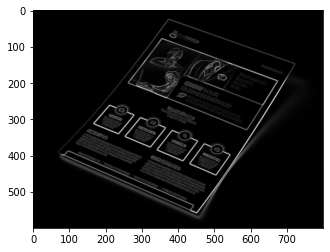

In [28]:
%time edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py)
plt.imshow(edge_sobel_py, cmap='gray')
plt.show()

* So sánh kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [29]:
print('Edge sobel:')
print("openCV vs Numpy: ", np.abs(edge_sobel_cv - edge_sobel_np).mean())
print("openCV vs Python (@jit): ", np.abs(edge_sobel_cv - edge_sobel_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(edge_sobel_py - edge_sobel_np).mean())

Edge sobel:
openCV vs Numpy:  1.2208719525697345
openCV vs Python (@jit):  1.2255306543772284
Python (@jit) vs Numpy:  0.004790280504679298


#### **Non-Maximum Suppression**

* Sử dụng @jit cho python thuần

In [30]:
@jit(cache=True)
def nonMaxSuppression(img, angle):
    Z = np.zeros(img.shape, np.int32)

    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            q, t = 255, 255
            
            if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
                q, t = img[r, c+1], img[r, c-1]
            elif 67.5 > angle[r,c] >= 22.5:
                q, t = img[r+1, c-1], img[r-1, c+1]
            elif 112.5 > angle[r,c] >= 67.5:
                q, t = img[r+1, c], img[r-1, c]
            elif 157.5 > angle[r,c] >= 112.5:
                q, t = img[r-1, c-1], img[r+1, c+1]
            
            if img[r,c] >=q and img[r,c] >=t:
                Z[r,c] = img[r,c]
            else:
                Z[r,c] = 0
    return Z

In [31]:
%time non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)

CPU times: user 577 ms, sys: 4.03 ms, total: 581 ms
Wall time: 584 ms


In [32]:
%time non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)

CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 3.02 ms


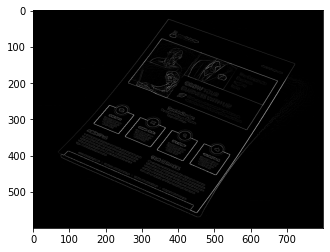

In [33]:
plt.imshow(non_max_sup_py, cmap='gray')
plt.show()

#### **Lọc ngưỡng**

* Sử dụng @jit cho python thuần

In [34]:
@jit(cache=True)
def hysteresisThreshold(img, min_thres, max_thres):

    canny_mask = np.zeros(img.shape, np.int32)
    max_val = img.max() * max_thres
    min_val = max_val * min_thres
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x] > max_val:
                canny_mask[y,x] = 255
            elif img[y,x] > min_val:
                is_edge = False
                for i in range(max(0, y-1), min(img.shape[0], y+2)):
                    for j in range(max(0, x-1), min(img.shape[1], x+2)):
                        if img[i,j] > max_val:
                            is_edge = True
                            canny_mask[y,x] = 255
                            break
                    if is_edge:
                        break
    return canny_mask

In [35]:
%time canny_edge_py = hysteresisThreshold(non_max_sup_py, 0.05, 0.15)

CPU times: user 921 ms, sys: 14 ms, total: 935 ms
Wall time: 936 ms


In [36]:
%time canny_edge_py = hysteresisThreshold(non_max_sup_py, 0.05, 0.15)

CPU times: user 2.67 ms, sys: 0 ns, total: 2.67 ms
Wall time: 2.84 ms


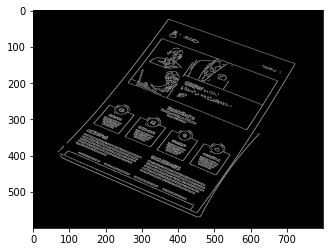

In [37]:
plt.imshow(canny_edge_py, cmap='gray')
plt.show()

* So sánh kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [38]:
print('Canny:')
print("openCV vs Python (@jit): ", np.abs(canny_edge_cv - canny_edge_py).mean())

Canny:
openCV vs Python (@jit):  4.702625


### Tìm biên của vật thể

* Dùng hàm của openCV

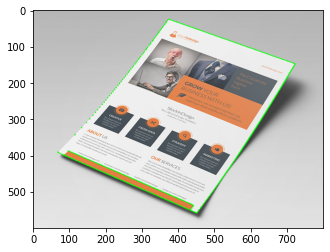

CPU times: user 319 ms, sys: 2.99 ms, total: 322 ms
Wall time: 352 ms


In [39]:
%%time 
contours,hierarchy = cv2.findContours(canny_edge_cv.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = sorted(contours, key = lambda x:cv2.arcLength(x,True), reverse = True)
output = img.copy()

for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
	if len(approx) == 4:
		screenCnt = approx
		break

cv2.drawContours(output, cnts[0], -1, (0, 255, 0), 2)

plt.imshow(output)
plt.show()